In [173]:
import lvm_read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
from scipy.optimize import curve_fit


In [174]:
noise_lvm = lvm_read.read('../data/Noise.lvm', read_from_pickle=False)
signals_lvm = lvm_read.read('../data/Signals.lvm', read_from_pickle=False)
frequency_noise_lvm = lvm_read.read('../data/frequency-noise/V_S_sweep.lvm', read_from_pickle=False)
V_S_sweep_lvm = lvm_read.read('../data/sweeps/V_S_sweep.lvm', read_from_pickle=False)
V_T_sweep_lvm = lvm_read.read('../data/sweeps/V_T_sweep.lvm', read_from_pickle=False)
V_W_sweep_lvm = lvm_read.read('../data/sweeps/V_W_sweep.lvm', read_from_pickle=False)

In [175]:
noise_df = pd.DataFrame(noise_lvm[0]['data'], columns=['time', 'V_S'])
signals_df = pd.DataFrame(signals_lvm[0]['data'], columns=['time', 'V_S', 'V_T', 'V_W'])
frequency_noise_df = pd.DataFrame(frequency_noise_lvm[0]['data'], columns=['frequency', 'amplitude', 'phase'])
V_S_sweep_df = pd.DataFrame(V_S_sweep_lvm[0]['data'], columns=['frequency', 'amplitude', 'phase'])
V_T_sweep_df = pd.DataFrame(V_T_sweep_lvm[0]['data'], columns=['frequency', 'amplitude', 'phase'])
V_W_sweep_df = pd.DataFrame(V_W_sweep_lvm[0]['data'], columns=['frequency', 'amplitude', 'phase'])

In [ ]:
# TODO: METTERE LA RESISTENZA DA 270 AL POSTO DI QUELLA DA 180 E RIPETERE TUTTE LE MISURE

In [176]:
# TODO: Delete badly triggered signals from frequency noise data (?)
# Trigger takes as the first point the first of the two points that caused the trigger to activate: so they are all below zero
# frequency_noise_df = frequency_noise_df[frequency_noise_df['phase'] < 0]

In [177]:
voltage_offset = noise_df['V_S'].mean() - 5    # TODO: rileggere il rumore a 0 volt, oppure chiedere se va bene sottrarre 5
voltage_error = noise_df['V_S'].std()

frequency_offset = frequency_noise_df['frequency'].mean() - 1000
frequency_error = frequency_noise_df['frequency'].std()

amplitude_offset = frequency_noise_df['amplitude'].mean() - 5
amplitude_error = frequency_noise_df['amplitude'].std()

phase_adjusted = pd.concat([frequency_noise_df.loc[frequency_noise_df['phase'] <= 0, 'phase'], frequency_noise_df.loc[frequency_noise_df['phase'] >= 180, 'phase'].apply(lambda x: x - 180)])

phase_offset = phase_adjusted.mean()
phase_error = phase_adjusted.std()


In [178]:
signals_df[['V_S', 'V_T', 'V_W']] = signals_df[['V_S', 'V_T', 'V_W']] - voltage_offset

V_S_sweep_df['frequency'] -= frequency_offset
V_T_sweep_df['frequency'] -= frequency_offset
V_W_sweep_df['frequency'] -= frequency_offset

V_S_sweep_df['amplitude'] -= amplitude_offset
V_T_sweep_df['amplitude'] -= amplitude_offset
V_W_sweep_df['amplitude'] -= amplitude_offset

# V_S_sweep_df['phase'] -= phase_offset     # The phase offset only affects the other two signals
V_T_sweep_df['phase'] -= phase_offset
V_W_sweep_df['phase'] -= phase_offset

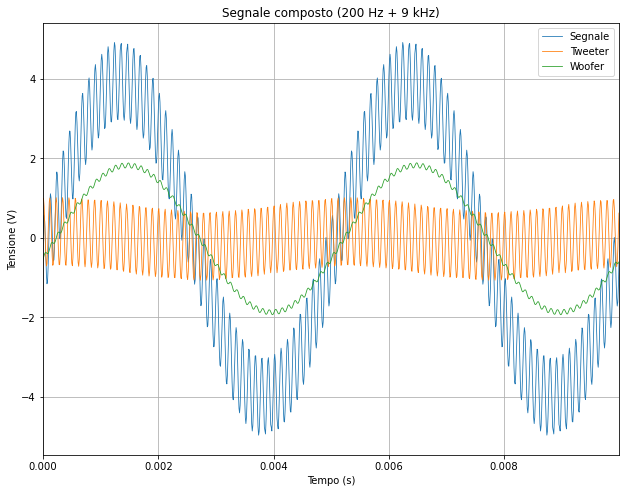

In [179]:
fig = plt.figure(figsize=(8,6))

axes = fig.add_axes([0,0,1,1])

axes.plot(signals_df['time'], signals_df['V_S'], label='Segnale', lw=0.8)
axes.plot(signals_df['time'], signals_df['V_T'], label='Tweeter', lw=0.8)
axes.plot(signals_df['time'], signals_df['V_W'], label='Woofer', lw=0.8)
axes.margins(x=0)
axes.set_xlabel('Tempo (s)')
axes.set_ylabel('Tensione (V)')
axes.set_title('Segnale composto (200 Hz + 9 kHz)')

axes.legend()
axes.grid()


In [180]:
# TODO: acquisire i segnali a tre frequenze: bassa, crossover e alta, e fare i grafici

In [181]:
R_int, R_L, R_W, R_C, R_T = symbols('R_{int} R_L R_W R_C R_T', real=True, positive=True)
L, C, w, V_0, t = symbols('L C \omega V_0 t', real=True, positive=True)
V = V_0*exp(I*w*t)

In [182]:
Z_T = R_C + R_T + 1/(C*w*I)
Z_W = R_L + R_W + L*w*I
Z_eq = 1/(1/Z_T+1/Z_W)
Z_tot = Z_eq + R_int
i = V / Z_tot
V_eq = i * Z_eq
i_T = V_eq / Z_T
i_W = V_eq / Z_W

V_T = simplify(i_T * R_T)
V_W = simplify(i_W * R_W)

A_T = Abs(V_T.subs({t: 0}))
A_W = Abs(V_W.subs({t: 0}))

phi_T = arg(V_T.subs({t: 0}))
phi_W = arg(V_W.subs({t: 0}))


In [183]:
numerical_values = {
    R_int: 50, R_L: 203, R_W: 179.79, R_C: 0, R_T: 471.72,
    L: 46.79 * 10**-3, C: 70 * 10**-9, V_0: 5
}
uncertainties = {
    R_L: 0.19135, R_W: 0.180906, R_T: 0.312274, L: 0.4679 * 10**-3, C: 0.7 * 10**-9
}

In [184]:
def calculate_uncertainty(Y, f = w/(2*pi)):
    sum = 0
    for x in uncertainties.keys():
        fixed_values = numerical_values.copy()
        x_value = fixed_values.pop(x)
        sum += pow((N(Y.subs(fixed_values).diff(x).subs({x: x_value, w: 2*pi*f}))) * uncertainties[x], 2)
    return sqrt(sum)

In [185]:
crossover_w = (solve(Eq(Abs(Z_T), Abs(Z_W)), w))[1] # 2 solutions: the last is positive
crossover_freq = crossover_w / (2*pi)
crossover_freq_val = N(crossover_freq.subs(numerical_values))
crossover_freq_err_val = calculate_uncertainty(crossover_freq, crossover_freq_val)
print('crossover_frequency (Hz) = ')
print(crossover_freq_val, ' +/- ', crossover_freq_err_val)


crossover_frequency (Hz) = 
2861.08888438996  +/-  20.2670957540082


In [186]:
crossover_amplitude = Abs(A_T).subs({w: crossover_w})
crossover_amplitude_val = N(crossover_amplitude.subs(numerical_values))
crossover_amplitude_err_val = calculate_uncertainty(crossover_amplitude, crossover_amplitude_val)
print('crossover amplitude (V) = ')
print(crossover_amplitude_val, ' +/- ', crossover_amplitude_err_val)


crossover amplitude (V) = 
2.43060836849706  +/-  0.0122277064244397


In [187]:
# 2 solutions: the last is positive
amplitude_match_w = (solve(Eq(A_T, A_W), w))[1]

In [188]:
amplitude_match_freq = amplitude_match_w / (2 * pi)
amplitude_match_freq_val = N(amplitude_match_freq.subs(numerical_values))
amplitude_match_freq_err_val = calculate_uncertainty(amplitude_match_freq, amplitude_match_freq_val)
print('amplitude match frequency (Hz) = ')
print(amplitude_match_freq_val, ' +/- ', amplitude_match_freq_err_val)


amplitude match frequency (Hz) = 
1536.25387121160  +/-  11.1702413027303


In [189]:
match_amplitude = Abs(A_T).subs({w: amplitude_match_w})
match_amplitude_val = N(match_amplitude.subs(numerical_values))
match_amplitude_err_val = calculate_uncertainty(match_amplitude, match_amplitude_val)
print('match amplitude (V) = ')
print(match_amplitude_val, ' +/- ', match_amplitude_err_val)

match amplitude (V) = 
1.42583847144393  +/-  0.00634120602784894


In [190]:
# from ideal circuit
phi_match_w_theory = sqrt((R_L+R_W) / (C*L * (R_C+R_T)))
phi_match_freq_theory = phi_match_w_theory / (2*pi)
phi_match_freq_theory_val = N(phi_match_freq_theory.subs(numerical_values))
phi_match_freq_theory_err_val = calculate_uncertainty(phi_match_freq_theory, phi_match_freq_theory_val)
print('phase match frequency (Hz) = ')
print(phi_match_freq_theory_val, ' +/- ', phi_match_freq_theory_err_val)


phase match frequency (Hz) = 
2505.14423686487  +/-  17.7543631269712


In [191]:
# Remove bad points in frequency analysis
to_drop = []
for i in range(1, V_S_sweep_df.shape[0] - 1):
    if (abs(V_S_sweep_df.loc[i, 'amplitude'] - (V_S_sweep_df.loc[i-1, 'amplitude'] + V_S_sweep_df.loc[i+1, 'amplitude']) / 2) > 0.05):
        to_drop.append(i)
for i in to_drop:
    V_S_sweep_df.drop(i, inplace=True)
    V_T_sweep_df.drop(i, inplace=True)
    V_W_sweep_df.drop(i, inplace=True)

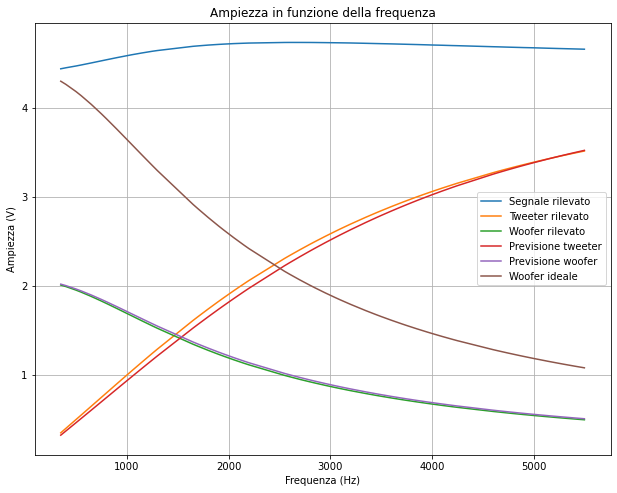

In [192]:
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Ampiezza in funzione della frequenza')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['amplitude'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['amplitude'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['amplitude'], label='Woofer rilevato')

"""
A_Ts = [N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()]
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = [N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()]
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')
"""

A_Ts = np.array([N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()])
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = np.array([N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()])
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')

boosted_woofer = A_Ws / numerical_values[R_W] * (numerical_values[R_W] + numerical_values[R_L])
axes.plot(V_W_sweep_df['frequency'], boosted_woofer, label='Woofer ideale')

axes.legend()
axes.grid()


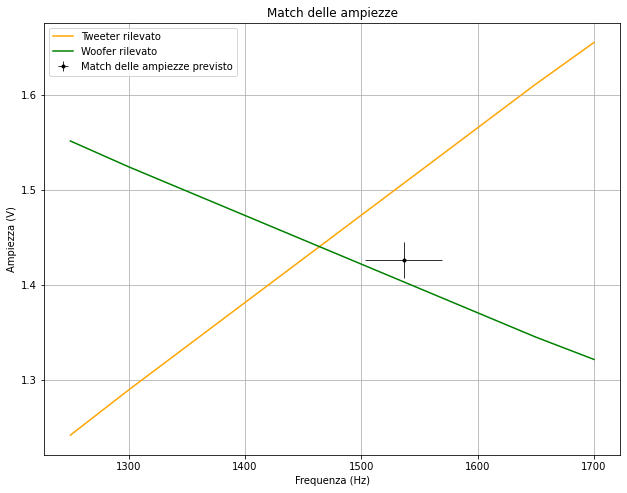

In [193]:
# Zoom sulla frequenza di match delle ampiezze
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Match delle ampiezze')

a = 1200
b = 1800
df_T = V_T_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]
df_W = V_W_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]

axes.plot(df_T['frequency'], df_T['amplitude'], label='Tweeter rilevato', color='orange')
axes.plot(df_W['frequency'], df_W['amplitude'], label='Woofer rilevato', color='green')
axes.errorbar(float(amplitude_match_freq_val), float(match_amplitude_val), xerr=3*float(amplitude_match_freq_err_val), yerr=3*float(match_amplitude_err_val), fmt='.k', lw=0.8, label='Match delle ampiezze previsto')

axes.legend()
axes.grid()


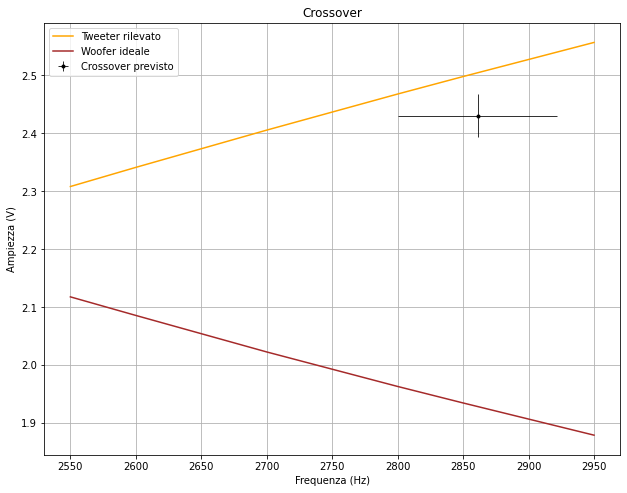

In [196]:
# Zoom sulla frequenza di match delle ampiezze
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0, 0, 1, 1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Crossover')

a = 2200
b = 3000
df_T = V_T_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]
df_W = V_W_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]

axes.plot(df_T['frequency'], df_T['amplitude'], label='Tweeter rilevato', color='orange')

boosted_woofer = df_W['amplitude'] / numerical_values[R_W] * (numerical_values[R_W] + numerical_values[R_L])
axes.plot(df_W['frequency'], boosted_woofer, label='Woofer ideale', color='brown')
axes.errorbar(float(crossover_freq_val), float(crossover_amplitude_val), xerr=3*float(crossover_freq_err_val),
              yerr=3*float(crossover_amplitude_err_val), fmt='.k', lw=0.8, label='Crossover previsto')

axes.legend()
axes.grid()


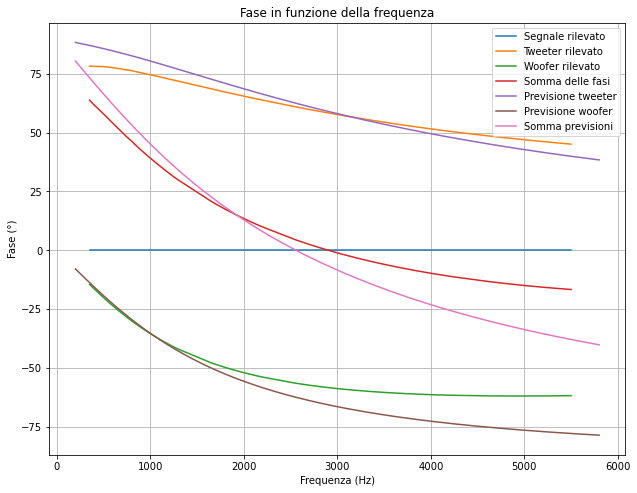

In [195]:
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Fase (°)')
axes.set_title('Fase in funzione della frequenza')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['phase'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['phase'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['phase'], label='Woofer rilevato')
axes.plot(V_W_sweep_df['frequency'], V_T_sweep_df['phase'] + V_W_sweep_df['phase'], label='Somma delle fasi')

fs = np.linspace(200, 5800, 200)

phi_Ts = np.array([N(phi_T.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ts, label='Previsione tweeter')

phi_Ws = np.array([N(phi_W.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ws, label='Previsione woofer')

axes.plot(fs, phi_Ts + phi_Ws, label='Somma previsioni')

axes.legend()
axes.grid()